Importing necessasry libariries



In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns


Loading the Data!


In [3]:
# Load your sales data
data = pd.read_csv('sales_data.csv')

# Display the first few rows of the dataset
print(data.head())


         date  sales
0  2023-01-01    200
1  2023-01-02    212
2  2023-01-03    224
3  2023-01-04    236
4  2023-01-05    248


Handle Missing Values
Convert Date Column to DateTime Format
Create Time-based Features
Generate Lag Features

In [4]:
# Convert date column to datetime
data['date'] = pd.to_datetime(data['date'])

# Create time-related features
data['day_of_week'] = data['date'].dt.dayofweek
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year

# Create lag features (previous sales)
data['lag_1'] = data['sales'].shift(1)
data['lag_7'] = data['sales'].shift(7)  # Lag of 1 week

# Drop rows with missing values created by lag features
data = data.dropna()

# Show the processed data
print(data.head())


         date  sales  day_of_week  month  year  lag_1  lag_7
7  2023-01-08    214            6      1  2023  272.0  200.0
8  2023-01-09    226            0      1  2023  214.0  212.0
9  2023-01-10    238            1      1  2023  226.0  224.0
10 2023-01-11    250            2      1  2023  238.0  236.0
11 2023-01-12    262            3      1  2023  250.0  248.0


Feature Selection
Defining the features as X and target cairbale as Y

In [5]:
# Define features and target variable
X = data[['day_of_week', 'month', 'year', 'lag_1', 'lag_7']]  # Add other relevant features if available
y = data['sales']

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Training the Model

In [6]:
# Initialize XGBoost Regressor model
model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)

# Train the model
model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

Model Prediction

In [7]:
# Predict sales for the test set
y_pred = model.predict(X_test)

# Evaluate the model's performance
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")


Root Mean Squared Error (RMSE): 5.351540435786244
Mean Absolute Error (MAE): 4.007540251079359


Visualize Predictions vs. Actual Sales

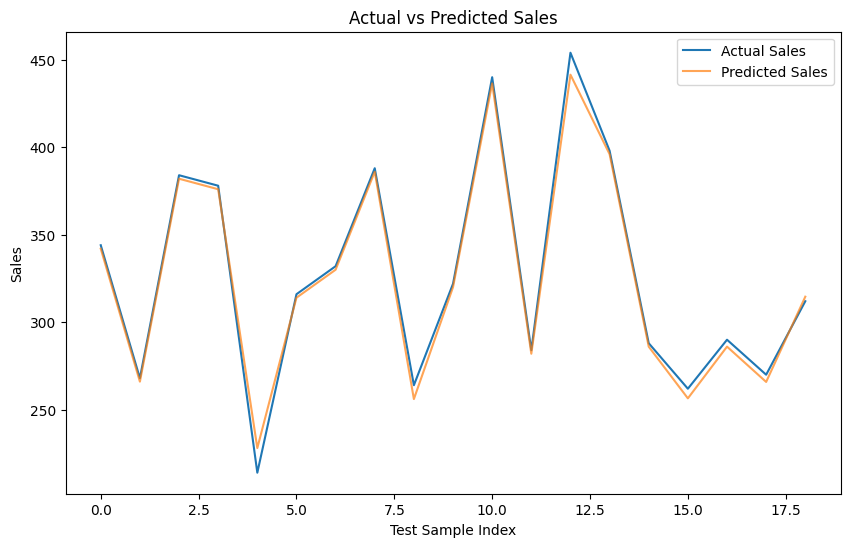

In [8]:
# Plot actual vs predicted sales
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual Sales')
plt.plot(y_pred, label='Predicted Sales', alpha=0.7)
plt.title('Actual vs Predicted Sales')
plt.xlabel('Test Sample Index')
plt.ylabel('Sales')
plt.legend()
plt.show()


 Hyperparameter Tuning

In [9]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=XGBRegressor(objective='reg:squarederror', random_state=42),
                           param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Best parameters found
print(f"Best Parameters: {grid_search.best_params_}")

# Best model performance
best_model = grid_search.best_estimator_


Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}


Model Evaluation with Tuned Model

In [10]:
# Predict using the best model from grid search
y_pred_tuned = best_model.predict(X_test)

# Evaluate the tuned model
rmse_tuned = np.sqrt(mean_squared_error(y_test, y_pred_tuned))
mae_tuned = mean_absolute_error(y_test, y_pred_tuned)

print(f"Tuned Model - RMSE: {rmse_tuned}")
print(f"Tuned Model - MAE: {mae_tuned}")


Tuned Model - RMSE: 5.351540435786244
Tuned Model - MAE: 4.007540251079359


saving the model for Deployment!

In [11]:
import joblib

# Save the trained model to a file
joblib.dump(model, 'sales_forecasting_model.pkl')

# Load the model (for future use)
# model = joblib.load('sales_forecasting_model.pkl')


['sales_forecasting_model.pkl']

 Automate Retraining
 For continuous improvement, automate retraining the model as new data arrives:

In [12]:
# Define a function for retraining the model with new data
def retrain_model(new_data, model_path='sales_forecasting_model.pkl'):
    # Preprocess new data
    new_data['date'] = pd.to_datetime(new_data['date'])
    new_data['day_of_week'] = new_data['date'].dt.dayofweek
    new_data['month'] = new_data['date'].dt.month
    new_data['year'] = new_data['date'].dt.year
    new_data['lag_1'] = new_data['sales'].shift(1)
    new_data['lag_7'] = new_data['sales'].shift(7)
    new_data = new_data.dropna()

    # Load the existing model
    model = joblib.load(model_path)

    # Split features and target
    X_new = new_data[['day_of_week', 'month', 'year', 'lag_1', 'lag_7']]
    y_new = new_data['sales']

    # Retrain the model
    model.fit(X_new, y_new)

    # Save the updated model
    joblib.dump(model, model_path)


In [13]:
from sklearn.metrics import r2_score

# Calculate R-squared
r2 = r2_score(y_test, y_pred)
print(f"R-squared (R²): {r2}")


R-squared (R²): 0.9928987163861892
